In [23]:
# Import necessary libraries and packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import cv2  
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
from sklearn.utils import shuffle
import os
from random import randint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
import seaborn as sn 
from keras.preprocessing.image import ImageDataGenerator

TRAIN_PATH = "../input/seg_train/seg_train/"
TEST_PATH = "../input/seg_test/seg_test/"
IMAGE_SIZE = 100

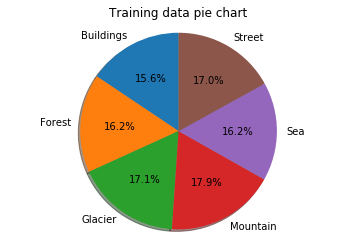

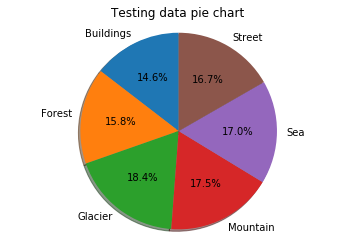

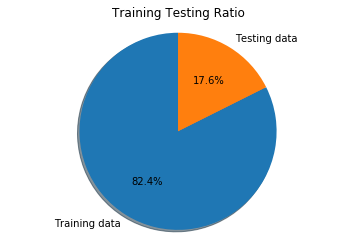

Number of training images: 14034
Number of testing images: 3000
Number of images for prediction: 7301


In [24]:
# Exploratory analysis
def exploratory_analysis(path):
    for category in os.listdir(path):
        if(category == "buildings"):
            no_buildings = len(os.listdir(path + "/" + "buildings"))
        elif(category == "forest"):
            no_forest = len(os.listdir(path + "/" + "forest"))
        elif(category == "glacier"):
            no_glacier = len(os.listdir(path + "/" + "glacier"))  
        elif(category == "mountain"):
            no_mountain = len(os.listdir(path + "/" + "mountain")) 
        elif(category == "sea"):
            no_sea = len(os.listdir(path + "/" + "sea"))   
        elif(category == "street"):
            no_street = len(os.listdir(path + "/" + "street"))
            
    total_images = no_buildings + no_forest + no_glacier + no_mountain + no_sea + no_street
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'
    percentages = [no_buildings/total_images, no_forest/total_images, no_glacier/total_images, no_mountain/total_images, no_sea/total_images, no_street/total_images]
    
    if(path == TEST_PATH):
        pie_chart_generate(percentages, labels, "Testing data pie chart")
    elif(path == TRAIN_PATH):
        pie_chart_generate(percentages, labels, "Training data pie chart")
    return total_images


def pie_chart_generate(percentages, labels, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.pie(percentages, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
    
# Training data pie chart 
number_training_images = exploratory_analysis(TRAIN_PATH)
# Testing data pie chart
number_testing_images = exploratory_analysis(TEST_PATH)
# Pie chart of the ratio of training and testing data
training_testing_ratio = [number_training_images/(number_training_images + number_testing_images), number_testing_images/(number_training_images + number_testing_images)]
pie_chart_generate(training_testing_ratio, ['Training data', 'Testing data'], 'Training Testing Ratio')
print("Number of training images: " + str(number_training_images))
print("Number of testing images: " + str(number_testing_images))
print("Number of images for prediction: " + str(len(os.listdir("../input/seg_pred/seg_pred/"))))


In [25]:
#Preprocess data 
def load_data(path):
    data = []
    labels = []
    for category in os.listdir(path):
        if(category == "buildings"):
            label = 0
        elif(category == "forest"):
            label = 1
        elif(category == "glacier"):
            label = 2  
        elif(category == "mountain"):
            label = 3  
        elif(category == "sea"):
            label = 4   
        elif(category == "street"):
            label = 5 

        training_subfolder_path = path + "/" + category
        
        for file in os.listdir(training_subfolder_path):
            image_path = training_subfolder_path + "/" + file
            image = cv2.imread(image_path)
            #Resize all images so they all have the same size
            image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
            image = np.array(image)
            #Standardize data by dividing by 255
            image = image.astype('float32')/255.0
            data.append(image)
            labels.append(label)
    #Shuffle data
    data, labels = shuffle(data, labels)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


In [26]:
# Load data
train_data, labels = load_data(TRAIN_PATH)

In [27]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,kernel_initializer='normal', activation='relu'))
model.add(Layers.Dense(100,kernel_initializer='normal', activation='relu'))
model.add(Layers.Dense(50,kernel_initializer='normal', activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6, activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 200)       5600      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 180)       324180    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 19, 180)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 180)       291780    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 140)       226940    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 100)       126100    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 50)        45050     
__________

In [28]:
# Fit model (train model normally)
trained = model.fit(train_data,labels,epochs=35,validation_split=0.30)

Train on 9823 samples, validate on 4211 samples
9823/9823 [==============================] - 25s 3ms/sample - loss: 1.5869 - acc: 0.3356 - val_loss: 1.3227 - val_acc: 0.4733


In [29]:
# Run this code to train the model with data augmentation or skip it 
# and run the next cell to check the metrics of the trained model above
train_data1 = np.array(train_data, copy=True) 
labels1 = np.array(labels, copy=True) 

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    )
datagen.fit(train_data)
# Concatenating the old data with the augmented data
result_x  = np.concatenate((train_data, train_data1), axis=0)
result_y  = np.concatenate((labels, labels1), axis=0)
# fits the model on batches with real-time data augmentation:
# Uncomment this to try data augmentation
# trained = model.fit_generator(datagen.flow(result_x, result_y, batch_size=35),
#                    steps_per_epoch=len(result_x) / 32, epochs = 20)

IndentationError: unexpected indent (<ipython-input-29-15eae543e4be>, line 18)

In [ ]:
# Metrics
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Prediction on testing set
test_images,test_labels = load_data('../input/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)


In [ ]:
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'forest']
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=categories, yticklabels=categories, ax = ax)
ax.set_title('Confusion matrix')
plt.show()